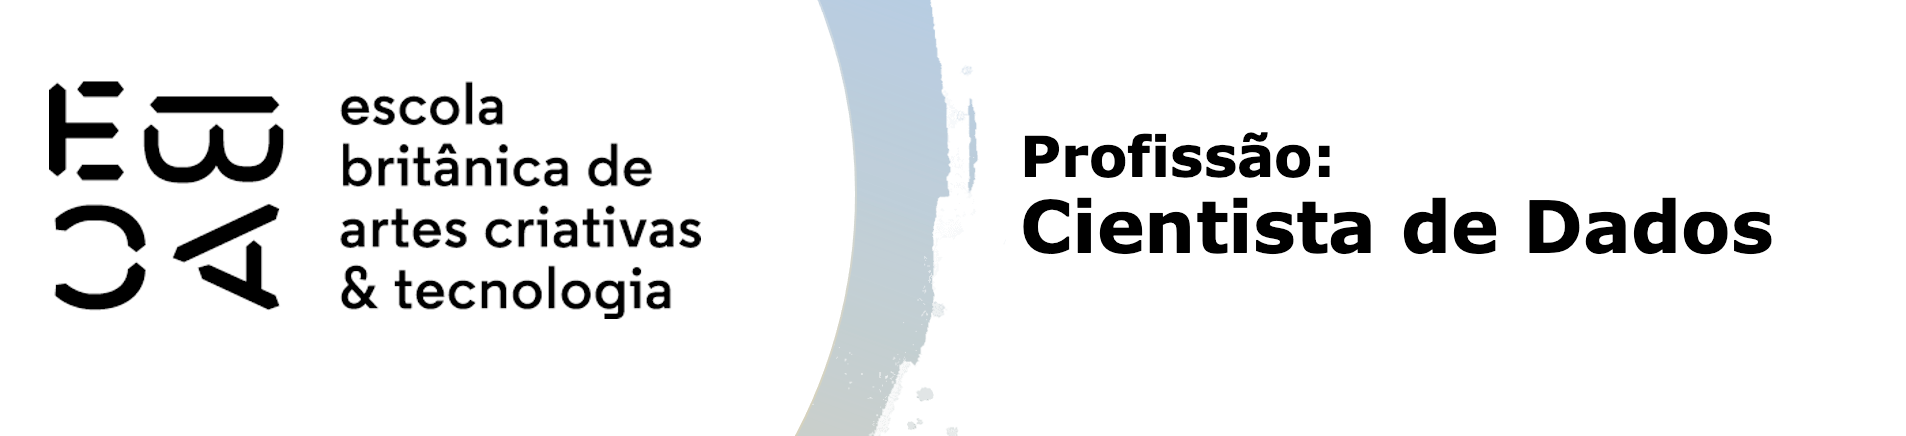

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
# Importe de bibliotecas
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Importe de dados
df = pd.read_pickle('./data/base_nfp.pkl')
df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Mercado
1,43.101.310/0001-05,AUTO POSTO ZANWAL LTDA EPP,2894,2017-06-30,50.00,2017-06-30,0.00,Liberado,2017,1,0.000000,0,Auto posto
2,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,699,2017-06-30,27.00,2017-06-30,0.44,Liberado,2017,1,0.016296,1,Restaurantes
3,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,698,2017-06-30,111.50,2017-06-30,1.81,Liberado,2017,1,0.016233,1,Restaurantes
4,23.750.257/0001-66,OFICINA DO TRIGO PASTIFICIO PANIFICADORA BAR E RE,694,2017-06-30,125.00,2017-06-30,2.03,Liberado,2017,1,0.016240,1,Restaurantes


In [3]:
# Verificando a base
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187646 entries, 0 to 187645
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   CNPJ emit.           187646 non-null  object        
 1   Emitente             187646 non-null  object        
 2   No.                  187646 non-null  int64         
 3   Data Emissão         187646 non-null  datetime64[ns]
 4   Valor NF             187646 non-null  float64       
 5   Data Registro        187646 non-null  datetime64[ns]
 6   Créditos             187646 non-null  float64       
 7   Situação do Crédito  187646 non-null  category      
 8   Ano                  187646 non-null  int64         
 9   Semestre             187646 non-null  int64         
 10  Retorno              186666 non-null  float64       
 11  flag_credito         187646 non-null  int64         
 12  categoria            187646 non-null  object        
dtypes: category(1)

In [4]:
# Pegando dados à partir de 2020
df_copy = df[df['Data Emissão'] >= '2020-01-01'].copy()
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86956 entries, 64598 to 187645
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   CNPJ emit.           86956 non-null  object        
 1   Emitente             86956 non-null  object        
 2   No.                  86956 non-null  int64         
 3   Data Emissão         86956 non-null  datetime64[ns]
 4   Valor NF             86956 non-null  float64       
 5   Data Registro        86956 non-null  datetime64[ns]
 6   Créditos             86956 non-null  float64       
 7   Situação do Crédito  86956 non-null  category      
 8   Ano                  86956 non-null  int64         
 9   Semestre             86956 non-null  int64         
 10  Retorno              86000 non-null  float64       
 11  flag_credito         86956 non-null  int64         
 12  categoria            86956 non-null  object        
dtypes: category(1), datetime64[ns](

## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [5]:
# Criando as novas variáveis relacionadas a data
df_copy['dia_semana'] = df_copy['Data Emissão'].dt.day_of_week
df_copy['fim_de_semana'] = df_copy['Data Emissão'].dt.day_of_week > 4
df_copy['dia_mes'] = df_copy['Data Emissão'].dt.day
df_copy['trimestre'] = df_copy['Data Emissão'].dt.quarter
df_copy.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,dia_semana,fim_de_semana,dia_mes,trimestre
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido,2,False,1,1
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado,2,False,1,1
64600,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,2020-01-01,35.90,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Alimentos,2,False,1,1
64601,61.412.110/0307-39,DROGARIA SAO PAULO S A,234178,2020-01-01,21.77,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Farmácia,2,False,1,1
64602,46.952.032/0001-98,PANIFICADORA E CONFEITARIA QUELUZ LTDA,3305,2020-01-01,80.95,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Restaurantes,2,False,1,1


In [6]:
# Criando as variáveis categóricas relacionadas a valor
df_copy['valor_nf_5'] = pd.qcut(df_copy['Valor NF'], 5)
df_copy['valor_nf_10'] = pd.qcut(df_copy['Valor NF'], 10)
df_copy['valor_nf_20'] = pd.qcut(df_copy['Valor NF'], 20)
df_copy['valor_nf_50'] = pd.qcut(df_copy['Valor NF'], 50)
df_copy.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,flag_credito,categoria,dia_semana,fim_de_semana,dia_mes,trimestre,valor_nf_5,valor_nf_10,valor_nf_20,valor_nf_50
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,...,0,não definido,2,False,1,1,"(49.04, 90.82]","(66.205, 90.82]","(77.9, 90.82]","(75.037, 79.99]"
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,...,0,Mercado,2,False,1,1,"(-0.001, 24.05]","(13.54, 24.05]","(18.97, 24.05]","(21.98, 24.05]"
64600,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,2020-01-01,35.90,2020-08-01,0.0,A Calcular,2019,2,...,0,Alimentos,2,False,1,1,"(24.05, 49.04]","(35.48, 49.04]","(35.48, 41.562]","(35.48, 37.95]"
64601,61.412.110/0307-39,DROGARIA SAO PAULO S A,234178,2020-01-01,21.77,2020-08-01,0.0,A Calcular,2019,2,...,0,Farmácia,2,False,1,1,"(-0.001, 24.05]","(13.54, 24.05]","(18.97, 24.05]","(19.95, 21.98]"
64602,46.952.032/0001-98,PANIFICADORA E CONFEITARIA QUELUZ LTDA,3305,2020-01-01,80.95,2020-08-01,0.0,A Calcular,2019,2,...,0,Restaurantes,2,False,1,1,"(49.04, 90.82]","(66.205, 90.82]","(77.9, 90.82]","(79.99, 85.4]"


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [7]:
# Verificando as classes das variáveis
df_copy.dtypes

CNPJ emit.                     object
Emitente                       object
No.                             int64
Data Emissão           datetime64[ns]
Valor NF                      float64
Data Registro          datetime64[ns]
Créditos                      float64
Situação do Crédito          category
Ano                             int64
Semestre                        int64
Retorno                       float64
flag_credito                    int64
categoria                      object
dia_semana                      int32
fim_de_semana                    bool
dia_mes                         int32
trimestre                       int32
valor_nf_5                   category
valor_nf_10                  category
valor_nf_20                  category
valor_nf_50                  category
dtype: object

In [8]:
# Instanciando a DataFrame que receberá os metadados para calculo de IV
variaveis = [
        "Situação do Crédito",
        "Ano",
        'Retorno',
        "CNPJ emit.",
        "Emitente",
        "No.",
        "Data Emissão",
        "Valor NF",
        "Data Registro",
        "Créditos",
]
df_copy_metadados = df_copy.drop(columns=variaveis)
metadados = pd.DataFrame({"dtypes": df_copy_metadados.dtypes})
metadados

,dtypes
Semestre,int64
flag_credito,int64
categoria,object
dia_semana,int32
fim_de_semana,bool
dia_mes,int32
trimestre,int32
valor_nf_5,category
valor_nf_10,category
valor_nf_20,category


In [9]:
# Inserindo coluna com informação de variável resposta e explicativas
metadados['papel'] = 'covariavel'
metadados.loc['flag_credito','papel'] = 'resposta'
metadados['nunique'] = df_copy_metadados.nunique()
metadados

,dtypes,papel,nunique
Semestre,int64,covariavel,2
flag_credito,int64,resposta,2
categoria,object,covariavel,9
dia_semana,int32,covariavel,7
fim_de_semana,bool,covariavel,2
dia_mes,int32,covariavel,31
trimestre,int32,covariavel,4
valor_nf_5,category,covariavel,5
valor_nf_10,category,covariavel,10
valor_nf_20,category,covariavel,20


In [10]:
# Definindo função que vai calcular o IV para cada coluna
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

iv = IV(df_copy_metadados.fim_de_semana, df_copy_metadados.flag_credito)
iv

0.004598647330024019

In [11]:
# Calculando IV de cada variável e alimentando a DataFrame metadados
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'nunique']>51):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_copy_metadados[var],5,duplicates='drop'), df_copy_metadados.flag_credito)
    else: 
        metadados.loc[var, 'IV'] = IV(df_copy_metadados[var], df_copy_metadados.flag_credito)
    
metadados

,dtypes,papel,nunique,IV
Semestre,int64,covariavel,2,0.004874
flag_credito,int64,resposta,2,NaN
categoria,object,covariavel,9,0.278826
dia_semana,int32,covariavel,7,0.005878
fim_de_semana,bool,covariavel,2,0.004599
dia_mes,int32,covariavel,31,0.015128
trimestre,int32,covariavel,4,0.003554
valor_nf_5,category,covariavel,5,0.038990
valor_nf_10,category,covariavel,10,0.059107
valor_nf_20,category,covariavel,20,0.078348


In [12]:
# Definindo função que classifica segundo Siddiqi os IV
def iv_categ(i: float, tab_iv: int) -> str:
    if 0 <= i <= 0.02:
        return "Inútil"
    if 0.02 < i <= 0.1:
        return "Fraco"
    if 0.1 < i <= 0.3:
        return "Médio"
    if 0.3 < i <= 0.5:
        return "Forte"
    if i > 0.5:
        if i != np.inf:
            return "Suspeito de tão alto"
        else:
            return "Não calculado"

In [13]:
# Classificando e inserindo no DataFrame de metadados
metadados['IV_Siddiqi'] = metadados['IV'].apply(iv_categ, args=(1,))
metadados

,dtypes,papel,nunique,IV,IV_Siddiqi
Semestre,int64,covariavel,2,0.004874,Inútil
flag_credito,int64,resposta,2,NaN,None
categoria,object,covariavel,9,0.278826,Médio
dia_semana,int32,covariavel,7,0.005878,Inútil
fim_de_semana,bool,covariavel,2,0.004599,Inútil
dia_mes,int32,covariavel,31,0.015128,Inútil
trimestre,int32,covariavel,4,0.003554,Inútil
valor_nf_5,category,covariavel,5,0.038990,Fraco
valor_nf_10,category,covariavel,10,0.059107,Fraco
valor_nf_20,category,covariavel,20,0.078348,Fraco


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?

R.: A variável com maior IV foi a *categoria* (0,279) seguido da categorica de Valor da NF com 50 quartis (*valor_nf_50* 0,122)

- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

R.: Sim, aparentemente, quanto maior o número de categorias, maior o IV

<div align='center'><br>

|Categoria|Núm de quartis|IV|Siddiqi|
|-|-|-|-|
|valor_nf_5|5|0.038990|Fraco|
|valor_nf_10|10|0.059107|Fraco|
|valor_nf_20|20|0.078348|Fraco|
|valor_nf_50|50|0.122257|Médio|

</div>

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

In [14]:
# Instanciando a DataFrame para descrição por tempo
df_copy_trimestre = df_copy[['Data Emissão','categoria','flag_credito']].groupby(['Data Emissão','categoria']).sum().reset_index()
df_copy_trimestre['mês'] = df_copy_trimestre['Data Emissão'].dt.month
total_registros = df_copy_trimestre['flag_credito'].sum().sum()
df_copy_trimestre['tx_evento'] = df_copy_trimestre['flag_credito']/total_registros

df_copy_trimestre.head()

,Data Emissão,categoria,flag_credito,mês,tx_evento
0,2020-01-01,Alimentos,3,1,0.000080
1,2020-01-01,Auto posto,0,1,0.000000
2,2020-01-01,Construção,1,1,0.000027
3,2020-01-01,Farmácia,0,1,0.000000
4,2020-01-01,Mercado,1,1,0.000027


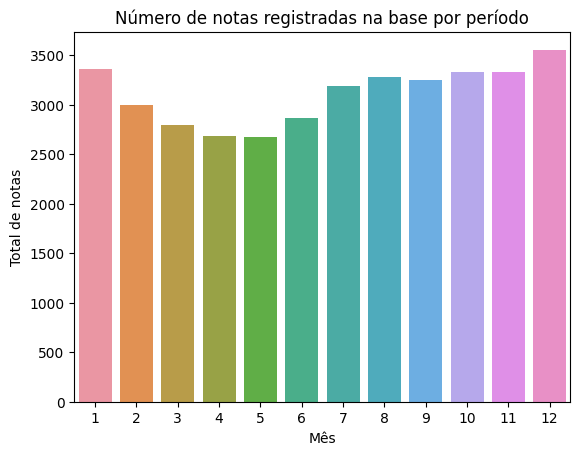

In [15]:
plt.title("Número de notas registradas na base por período")
sns.barplot(
    x='mês',
    y='flag_credito',
    data=df_copy_trimestre[['mês','flag_credito']].groupby('mês').sum().reset_index()
)
plt.xlabel("Mês")
plt.ylabel("Total de notas")
plt.show()

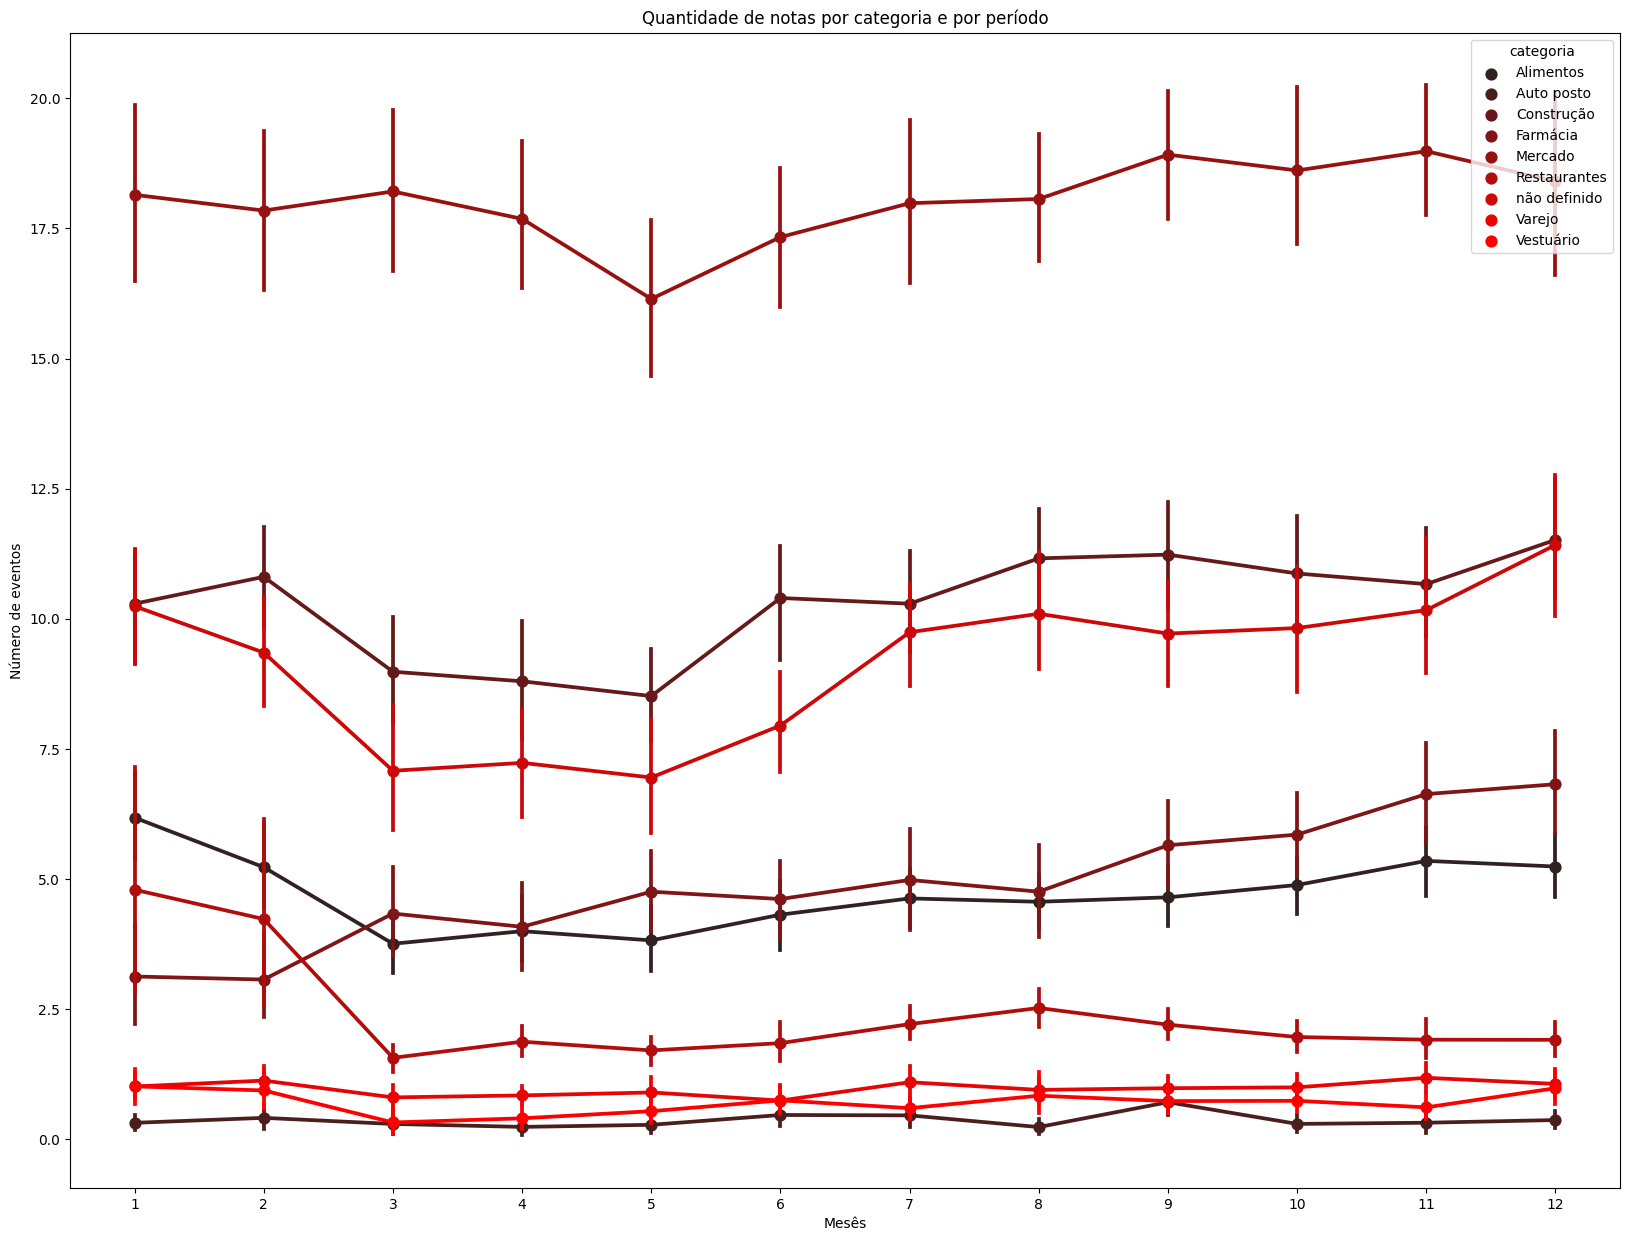

In [16]:
fig, ax = plt.subplots(figsize=(20, 15))
plt.title("Quantidade de notas por categoria e por período")
sns.pointplot(
    x='mês',
    y='flag_credito',
    hue='categoria',
    # errorbar=None,
    ax=ax,
    color='r',
    data=df_copy_trimestre.reset_index(),
)
plt.xlabel('Mesês')
plt.ylabel('Número de eventos')
plt.show()

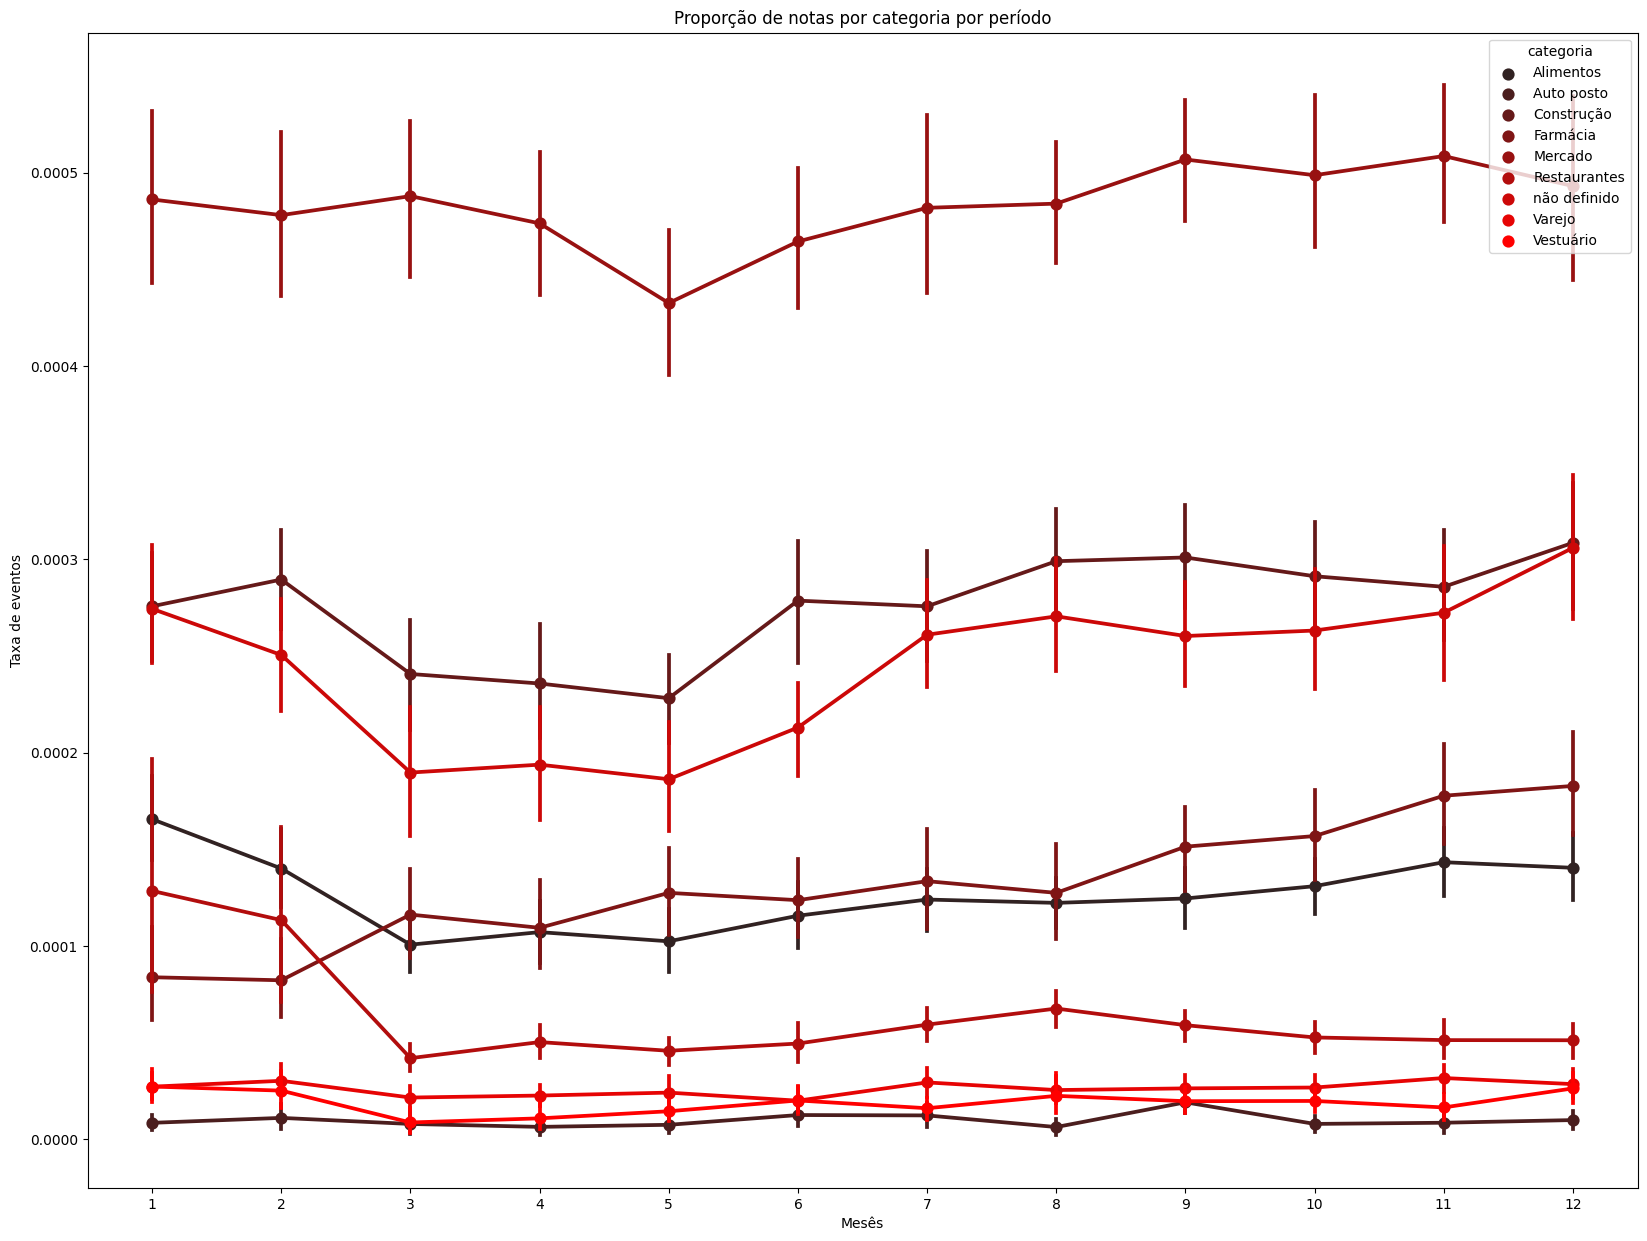

In [17]:
fig, ax = plt.subplots(figsize=(20, 15))
plt.title("Proporção de notas por categoria por período")
sns.pointplot(
    x='mês',
    y='tx_evento',
    hue='categoria',
    ax=ax,
    color='r',
    data=df_copy_trimestre.reset_index(),
)
plt.xlabel('Mesês')
plt.ylabel('Taxa de eventos')
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

In [18]:
# Criando uma nova variável com o mês por ano da Data de Emissão
df_copy['ano_mes'] = df_copy['Data Emissão'].dt.strftime('%Y-%m')
df_copy['ano_mes'] = pd.to_datetime(df_copy['ano_mes'])
df_copy.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,categoria,dia_semana,fim_de_semana,dia_mes,trimestre,valor_nf_5,valor_nf_10,valor_nf_20,valor_nf_50,ano_mes
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,...,não definido,2,False,1,1,"(49.04, 90.82]","(66.205, 90.82]","(77.9, 90.82]","(75.037, 79.99]",2020-01-01
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,...,Mercado,2,False,1,1,"(-0.001, 24.05]","(13.54, 24.05]","(18.97, 24.05]","(21.98, 24.05]",2020-01-01
64600,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,2020-01-01,35.90,2020-08-01,0.0,A Calcular,2019,2,...,Alimentos,2,False,1,1,"(24.05, 49.04]","(35.48, 49.04]","(35.48, 41.562]","(35.48, 37.95]",2020-01-01
64601,61.412.110/0307-39,DROGARIA SAO PAULO S A,234178,2020-01-01,21.77,2020-08-01,0.0,A Calcular,2019,2,...,Farmácia,2,False,1,1,"(-0.001, 24.05]","(13.54, 24.05]","(18.97, 24.05]","(19.95, 21.98]",2020-01-01
64602,46.952.032/0001-98,PANIFICADORA E CONFEITARIA QUELUZ LTDA,3305,2020-01-01,80.95,2020-08-01,0.0,A Calcular,2019,2,...,Restaurantes,2,False,1,1,"(49.04, 90.82]","(66.205, 90.82]","(77.9, 90.82]","(79.99, 85.4]",2020-01-01


In [19]:
# Agrupando por mês/ano e categoria
df_copy_categ = df_copy[['ano_mes','flag_credito','categoria','Ano']].groupby(['ano_mes','categoria','flag_credito']).count().unstack(level=2)
df_copy_categ.head(20)

Ano     
flag_credito               0    1
ano_mes    categoria             
2020-01-01 Alimentos      56  222
           Auto posto     30   10
           Construção    305  345
           Farmácia      292   63
           Mercado       538  478
           Restaurantes   35  211
           Varejo         95   32
           Vestuário      63   33
           não definido  340  328
2020-02-01 Alimentos      69  167
           Auto posto     17    7
           Construção    391  315
           Farmácia      311   77
           Mercado       700  483
           Restaurantes   30  191
           Varejo         80   34
           Vestuário      50   36
           não definido  419  266
2020-03-01 Alimentos      77  110
           Auto posto     19    5

In [20]:
# Caluclando o percentual de evento e não evento para obtenção do WOE
rotulo_ev, rotulo_nev = (('Ano', 1), ('Ano', 0))

df_copy_categ['pct_evento']     = df_copy_categ[rotulo_ev]/df_copy_categ[rotulo_ev].groupby(level=0).sum()
df_copy_categ['pct_nao_evento'] = df_copy_categ[rotulo_nev]/df_copy_categ[rotulo_nev].groupby(level=0).sum()
df_copy_categ['WOE'] = np.log(df_copy_categ.pct_evento/df_copy_categ.pct_nao_evento)
df_copy_categ.head(20)

Ano      pct_evento pct_nao_evento       WOE
flag_credito               0    1                                    
ano_mes    categoria                                                 
2020-01-01 Alimentos      56  222   0.128920       0.031927  1.395738
           Auto posto     30   10   0.005807       0.017104 -1.080200
           Construção    305  345   0.200348       0.173888  0.141645
           Farmácia      292   63   0.036585       0.166477 -1.515207
           Mercado       538  478   0.277584       0.306727 -0.099835
           Restaurantes   35  211   0.122532       0.019954  1.814923
           Varejo         95   32   0.018583       0.054162 -1.069729
           Vestuário      63   33   0.019164       0.035918 -0.628215
           não definido  340  328   0.190476       0.193843 -0.017520
2020-02-01 Alimentos      69  167   0.105964       0.033382  1.155096
           Auto posto     17    7   0.004442       0.008224 -0.616095
           Construção    391  315   0.199873       0.189163  0.055073
           Farmácia      311   77   0.048858       0.150460 -1.124779
           Mercado       700  483   0.306472       0.338655 -0.099855
           Restaurantes   30  191   0.121193       0.014514  2.122284
           Varejo         80   34   0.021574       0.038703 -0.584458
           Vestuário      50   36   0.022843       0.024190 -0.057296
           não definido  419  266   0.168782       0.202709 -0.183166
2020-03-01 Alimentos      77  110   0.086478       0.035112  0.901355
           Auto posto     19    5   0.003931       0.008664 -0.790321

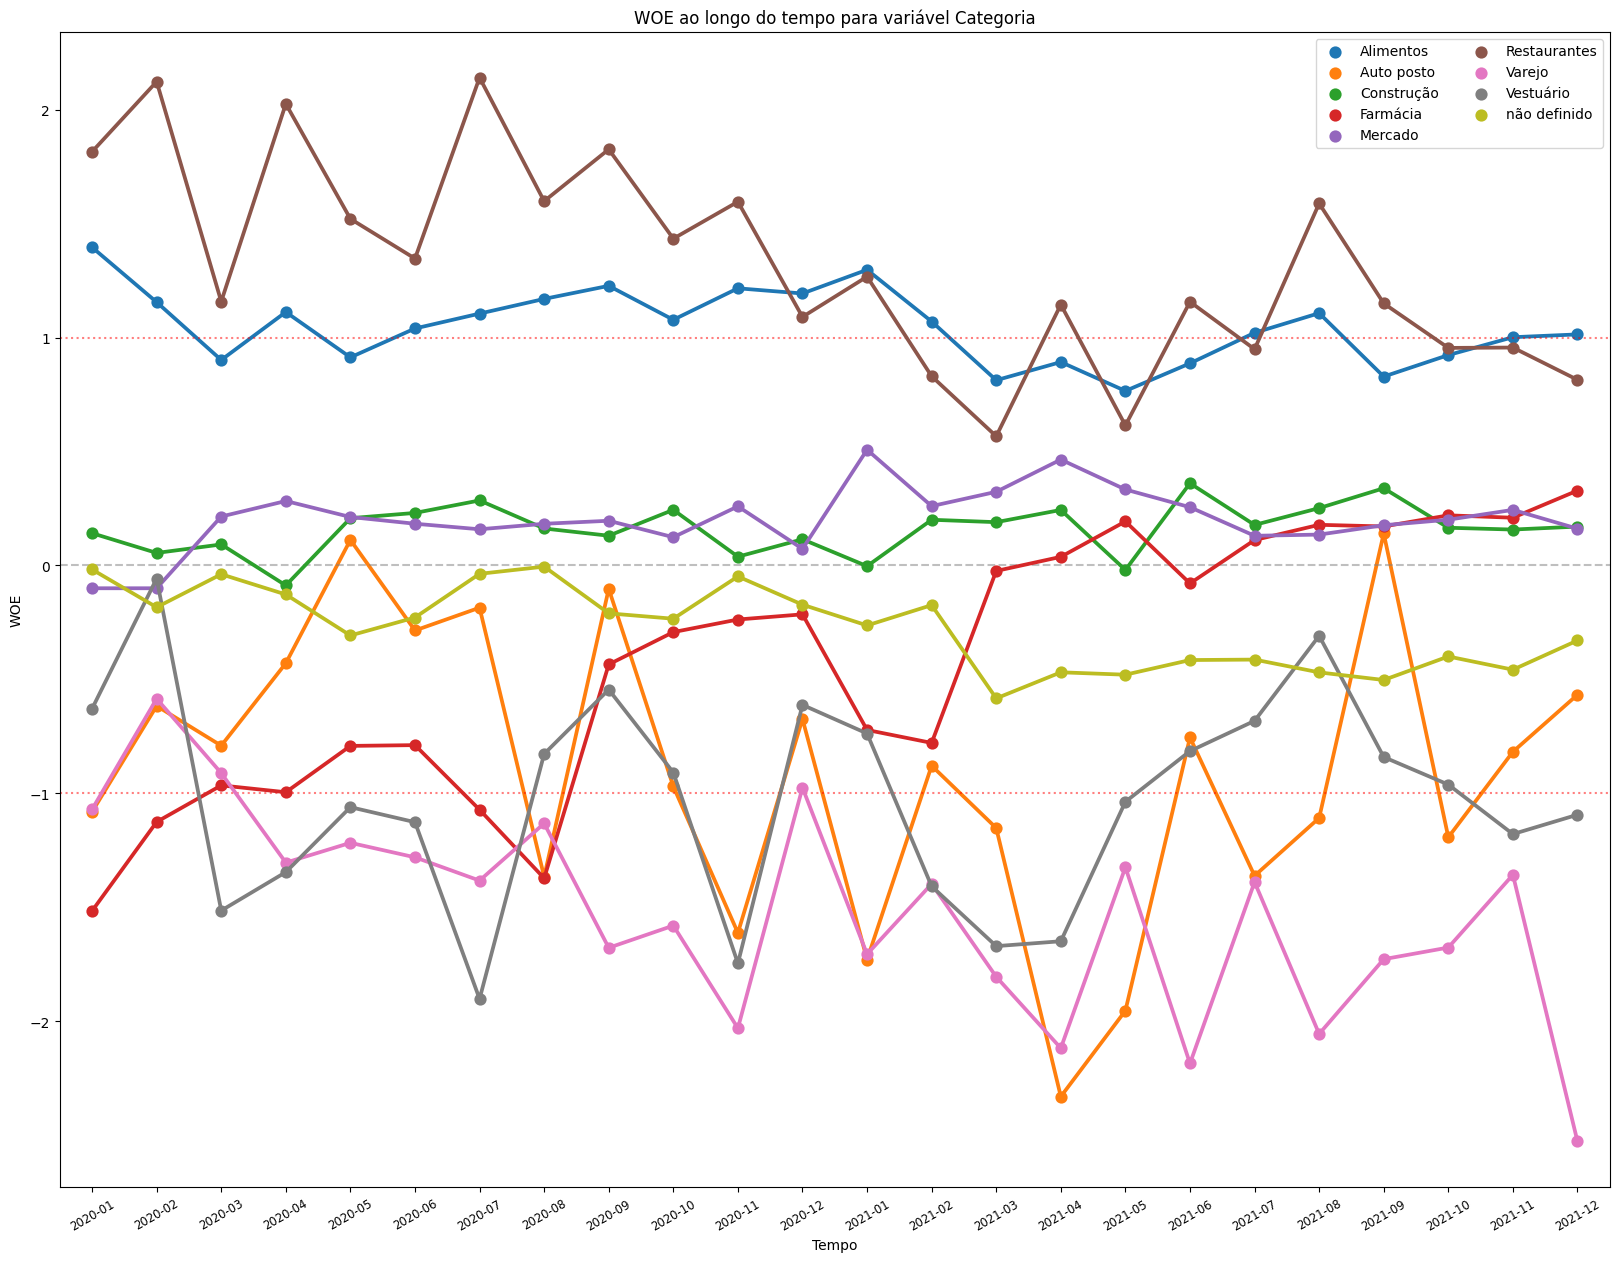

In [31]:
fig, ax = plt.subplots(figsize=(20, 15))
variavel='categoria'

# Comando principal do gráfico
sns.pointplot(data=df_copy_categ.reset_index(), y = 'WOE', x = 'ano_mes', hue=variavel, ax=ax)

# Rotacionar os rótulos do eixo X
labs = df_copy_categ.index.get_level_values(level=0).unique()
labs2 = [x.to_period('M') for x in labs]

ax.set_xticklabels(labs2,rotation=30, fontsize='small')
ax.legend(bbox_to_anchor=(1, 1), ncol=2)

#limites do gráfico - mostrando 1 e -1 para ter referência
ymax = max(1.2, max(df_copy_categ.WOE)+.2)
ymin = min(-1.2, min(df_copy_categ.WOE)-.2)
ax.set_ylim([ymin, ymax])

# Linhas de referência
ax.axhline(1, linestyle=':'  , color='red', alpha=.5)
ax.axhline(0, linestyle='--' , color='grey', alpha=.5)
ax.axhline(-1, linestyle=':' , color='red', alpha=.5)

# Títulos
ax.set_title(f'WOE ao longo do tempo para variável {variavel.capitalize()}')
ax.set_xlabel('Tempo')
plt.show()

In [22]:
# Calculando o IV por categoria com base no percentual de evento, de não evento e do WOE
iv_categ = ((df_copy_categ.pct_evento - df_copy_categ.pct_nao_evento)*df_copy_categ.WOE).groupby(level=1).sum().to_frame().reset_index()
iv_categ

,categoria,0
0,Alimentos,1.542020
1,Auto posto,0.135228
2,Construção,0.166127
3,Farmácia,1.127894
4,Mercado,0.457107
5,Restaurantes,1.188071
6,Varejo,2.755875
7,Vestuário,0.510156
8,não definido,0.512316


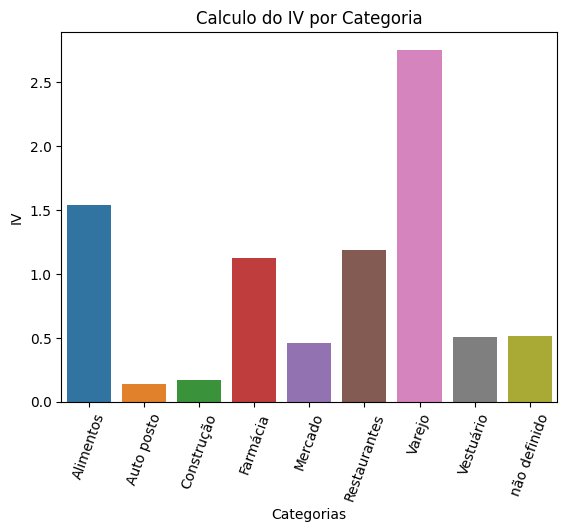

In [23]:
plt.title('Calculo do IV por Categoria')
sns.barplot(
    x='categoria',
    y=0,
    data=iv_categ
)
plt.xlabel('Categorias')
plt.ylabel('IV')
plt.xticks(rotation=70)
plt.show()

In [24]:
# Calculando o IV por flag credito com base no percentual de evento, de não evento e do WOE
iv_flag = ((df_copy_categ.pct_evento - df_copy_categ.pct_nao_evento)*df_copy_categ.WOE).groupby(level=0).sum()
iv_flag.head()

ano_mes
2020-01-01    0.585863
2020-02-01    0.446960
2020-03-01    0.259291
2020-04-01    0.383224
2020-05-01    0.275553
dtype: float64

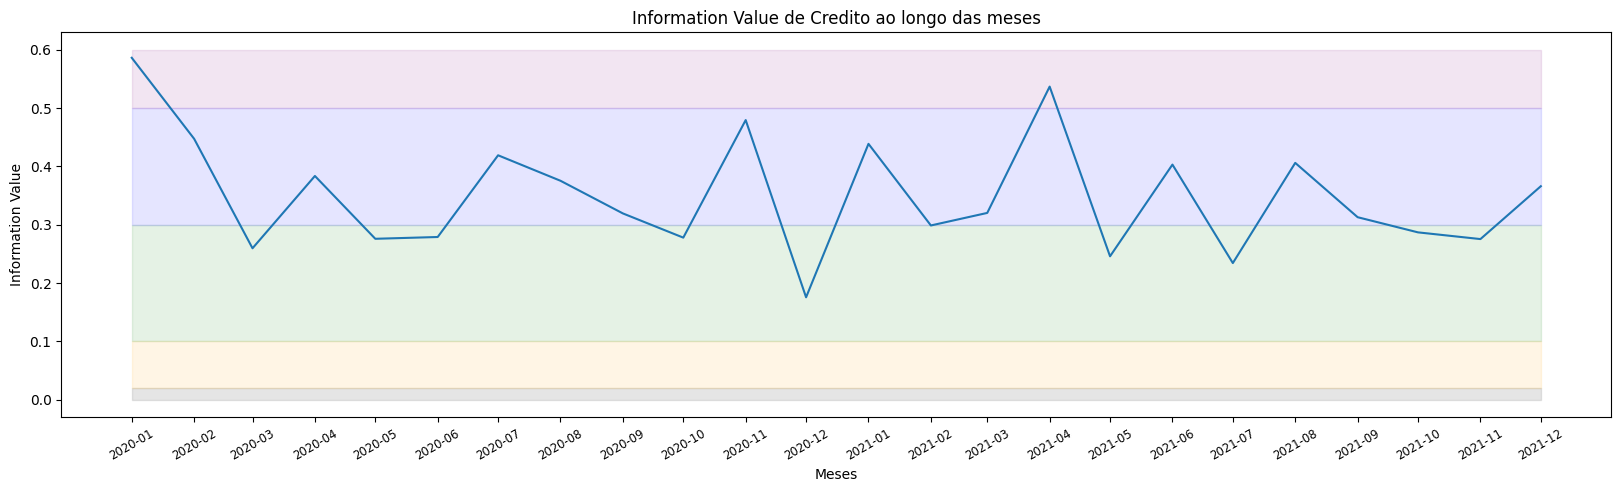

In [25]:
def plot_iv(IV):
    _, ax = plt.subplots(figsize=(20,5))
    a = [.02]*len(IV.index)
    b = [.1]*len(IV.index)
    c = [.3]*len(IV.index)
    d = [.5]*len(IV.index)
    e = [.6]*len(IV.index)

    ax.fill_between(IV.index, a, color='grey', alpha=.2)
    ax.fill_between(IV.index, a, b, color='orange', alpha=.1)
    ax.fill_between(IV.index, b, c, color='green', alpha=.1)
    ax.fill_between(IV.index, c, d, color='blue', alpha=.1)
    ax.fill_between(IV.index, d, e, color='purple', alpha=.1)
    ax.plot(IV)

    labs = IV.index.get_level_values(level=0).unique()
    labs2 = [x.to_period('M') for x in labs]

    ax.set_xticks(labs)
    ax.set_xticklabels(labs2,rotation=30, fontsize='small')

    ax.set_title("Information Value de Credito ao longo das meses")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Meses")
    
plot_iv(iv_flag)

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?

R.: Varejo, seguido de Alimentos, com Restaurante e Farmácias na sequência.

- Essas diferenças são estáveis no tempo?

R.: Não, as categorias ao longo do tempo tem valores de IV que se cruzam, com mudanças significativas.


Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.